# 5 домашнее задание

#### Импорт библиотек

In [1]:
from dataclasses import dataclass
from typing import Callable

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, t, mode
from sklearn.utils import resample

#### Настройки графиков

In [2]:
sns.set(style="whitegrid")

## Выбор распределения

Выберем распределение хи-квадрат. Пусть $z_1 , \ldots , z_{k}$ - совместно независимые стандартные нормальные случайные величины, то есть: $z_i \sim N(0,1)$. Тогда случайная величина $x = z_1 + z_2 + \ldots + z_k$ имеет распределение хи-квадрат с **$\mathbf{k}$ степенями свободы**, то есть $x \sim f_{\chi ^{2}(k)}(x)$, или, если записать по-другому: 
$$
    x = \sum_{i=1}^k z_i^2 \sim \chi^2(k)
$$

Возьмем готовую функцию для генерации значений из $\chi^2$ распределения из библиотеки **scipy**. Изобразим график при $k=5$ и $n=1000$.

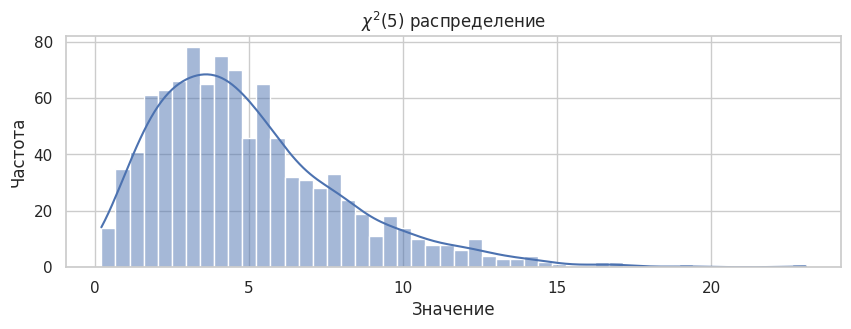

In [3]:
values = chi2.rvs(5, size=1_000)

plt.figure(figsize=(10, 3))
sns.histplot(values, 
             kde=True, 
             bins=50)

plt.title('$\chi^2(5)$ распределение')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.show()

## Задание №1
Для выбранного распределения сгенерируем выборки разного объема и проиллюстрируем сходимость выборочного среднего к математическому ожиданию.

Нам нужно продемонстировать центральную предельную теорему. Для примера возьмем $\chi^2(5)$, у которого $\mathbb{E}\chi^2(5) = 5$.

In [4]:
df = 5

In [5]:
n_samples = [5, 20] + [10 ** i for i in range(2, 9)]

data = {'Размер выборки': [],
        'Выборочное среднее': [],
        'Отклонение': []}

for size in n_samples:
    values = chi2.rvs(df, size=size)
    sample_mean = np.mean(values)
    deviation = np.abs(sample_mean - df)
    
    data['Размер выборки'].append(size)
    data['Выборочное среднее'].append(np.round(np.mean(values), 5))
    data['Отклонение'].append(np.round(np.abs(sample_mean - df), 5))

pd.DataFrame(data)

,Размер выборки,Выборочное среднее,Отклонение
0,5,4.33585,0.66415
1,20,4.84229,0.15771
2,100,4.93420,0.06580
3,1000,5.01214,0.01214
4,10000,4.95263,0.04737
5,100000,5.00797,0.00797
6,1000000,5.00053,0.00053
7,10000000,4.99994,0.00006
8,100000000,4.99951,0.00049


Теперь в виде графика.

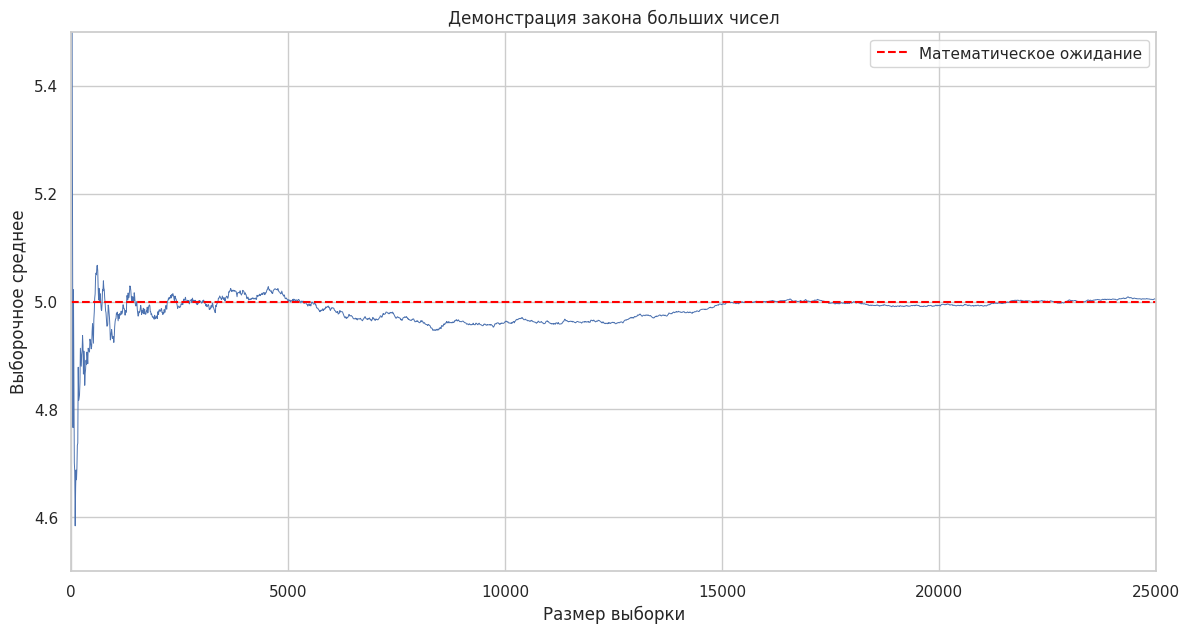

In [6]:
data = {'Размер выборки': [],
        'Выборочное среднее': []}
n = 25_000
values = chi2.rvs(df, size=n)

for size in range(1, n, 10):
    data['Размер выборки'].append(size)
    data['Выборочное среднее'].append(np.round(np.mean(values[:size]), 5))

plt.figure(figsize=(14, 7))

sns.lineplot(x="Размер выборки", 
             y='Выборочное среднее',
             data=pd.DataFrame(data),
             estimator=None,
             linewidth=0.7)

plt.axhline(df, 
            label='Математическое ожидание', 
            color='red',
            linestyle='dashed')

plt.ylim(df - 0.5, df + 0.5)
plt.xlim(0, n)
plt.legend()
plt.title('Демонстрация закона больших чисел')

plt.show()

## Задание №2
Наглядно продемонстрируем центральную предельную теорему в действии для хи квадрат распределения.

Нам нужно показать, что:
$$
    {\frac {S_{n}-\mu n}{\sigma {\sqrt n}}} \to N(0,1), \quad n \to \infty
$$
Где $S_n = \displaystyle \sum_{i=1}^n x_i$ и $x_i$ - последовательность независимых одинаково распределённых случайных величин, имеющих конечное математическое ожидание $\mu$ и дисперсию $\sigma^2$.

Возьмем $\chi^2(5)$, у которого $\mathbb{E}\chi^2(5) = 5$ и $\mathbb{D}\chi^2(5) = 5 \cdot 2 = 10$, тогда покажем, что:
$$
    {\frac {S_{n}-5n}{\sqrt{10n}}} \to N(0,1), \quad n \to \infty
$$
Где уже $x_i \sim \chi^2(5)$.

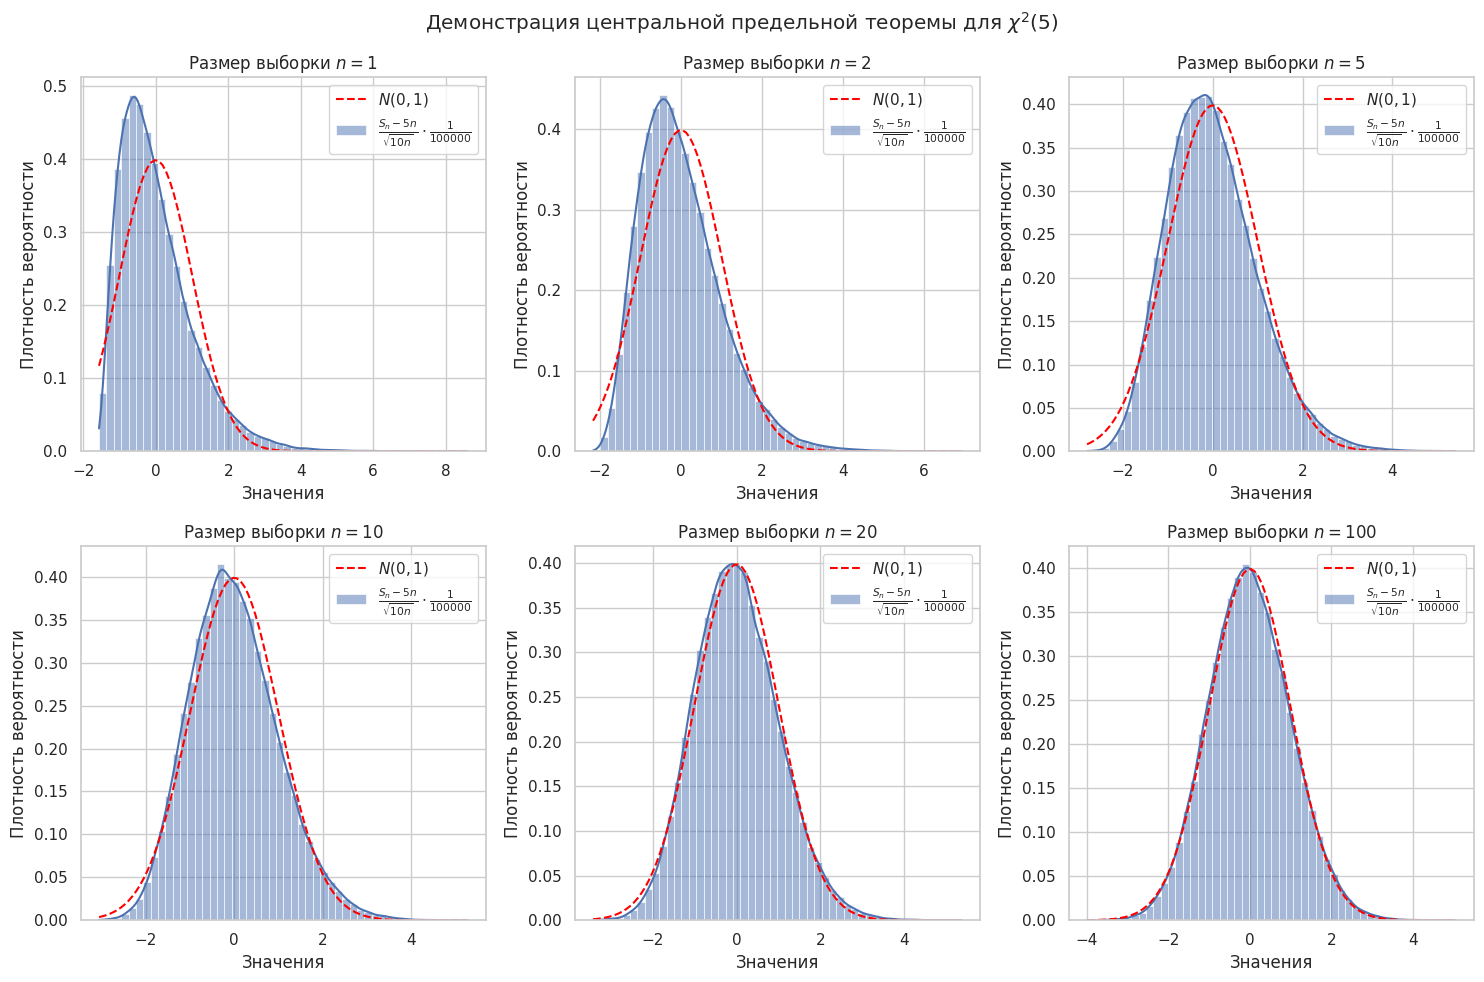

In [7]:
plt.figure(figsize=(15, 10))

for i, n in enumerate([1, 2, 5, 10, 20, 100], 1):
    plt.subplot(2, 3, i)
    values = chi2.rvs(df, size=(100_000, n)).sum(axis=1)
    values = (values - df * n) / np.sqrt(2 * df * n)
    sns.histplot(values, 
                 kde=True, 
                 bins=50, 
                 stat='density',
                 label='$\\frac{S_{n}-5n}'
                       '{\\sqrt{10n}} \\cdot'
                       '\\frac{1}{100000}$')
    plt.title(f'Размер выборки ${n=}$')
    plt.xlabel('Значения')
    plt.ylabel('Плотность вероятности')

    x = np.linspace(min(values), max(values), 100)
    y = norm.pdf(x, loc=0, scale=1)
    sns.lineplot({'Значения': y, 'Плотность вероятности': x}, 
                 y='Значения',
                 x='Плотность вероятности',
                 color='red',
                 linestyle='dashed',
                 label='$N(0, 1)$')

plt.suptitle('Демонстрация центральной предельной теоремы для $\chi^2(5)$')
plt.tight_layout()
plt.show()

## Задание №3

Сгенерируем три выборки $\chi^2(5)$ распределения маленького, среднего и большого размера. Напишем dataclass, чтобы сохранять названия выборок.

In [8]:
@dataclass
class Sample:
    values: np.ndarray
    name: str


small_sample = Sample(chi2.rvs(df, size=20), 'маленькая выборка')
medium_sample = Sample(chi2.rvs(df, size=200), 'средняя выборка')
large_sample = Sample(chi2.rvs(df, size=10_000), 'большая выборка')

samples = [small_sample, medium_sample, large_sample]

### Задание №3.1

Напишем функцию для построения асимптотического доверительный интервала для среднего значения на базе ЦПТ.
$$
    \hat{x} \ \pm \ z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}
$$
Где $z_{1-\frac{\alpha}{2}}$ - это квантиль нормального распределения для заданного уровня значимости. Будем использовать уровень значимости $\alpha = 0.05$. То есть $z_{0.975}$

In [10]:
def calc_ci_z(sample: np.ndarray, alpha: float = 0.05) -> tuple:
    z_sсore = norm.ppf(1 - alpha / 2)
    
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    
    margin_of_error = z_sсore * (sample_std / np.sqrt(len(sample)))
    confidence_interval = (sample_mean - margin_of_error, 
                           sample_mean + margin_of_error)
    interval_width = 2 * margin_of_error
    return ("Асимтотический доверительный интервал", 
           np.round(sample_mean, 4), 
           np.round(confidence_interval, 4), 
           np.round(interval_width, 4))

Для каждой выборки выведем асимптотический доверительный интервал для среднего значения.

Напишем функцию для вывода графиков

In [11]:
def show_graph(samples: list[Sample], 
               ci_type: str, 
               stat_func: Callable) -> None: 
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'Демонстрация {ci_type}')
    for i, sample in enumerate(samples):
        plt.subplot(2, 3, i + 1)
        _, sample_mean, confidence_interval, interval_width = \
            stat_func(sample.values)
        
        print(f'Значения {ci_type} для {sample.name}:'
              f'{confidence_interval}, его ширина {interval_width}')
        print(f"\t Выборочное среднее = {sample_mean}")
        sns.histplot(sample.values, 
                     bins=15, 
                     kde=True,
                     stat='density')
        plt.axvline(x=confidence_interval[0], 
                    color='red', 
                    linestyle='dashed', 
                    linewidth=2, 
                    label='Нижняя граница Д.И.')
        plt.axvline(x=confidence_interval[1], 
                    color='green', 
                    linestyle='dashed', 
                    linewidth=2, 
                    label='Верхняя граница Д.И.')
        plt.axvline(x=sample_mean, 
                    color='orange', 
                    linestyle='dashed', 
                    linewidth=2, 
                    label='Выборочное среднее')
        plt.title(f'{sample.name.capitalize()}')
        plt.xlabel('Значения')
        plt.ylabel('Плотность вероятности')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

Изобразим доверительные интервалы для каждой выборки.

Значения асимтотический интегрвал для среднего значения для маленькая выборка:[4.267  7.1626], его ширина 2.8956
	 Выборочное среднее = 5.7148
Значения асимтотический интегрвал для среднего значения для средняя выборка:[4.6253 5.5219], его ширина 0.8966
	 Выборочное среднее = 5.0736
Значения асимтотический интегрвал для среднего значения для большая выборка:[4.8965 5.0186], его ширина 0.1221
	 Выборочное среднее = 4.9576


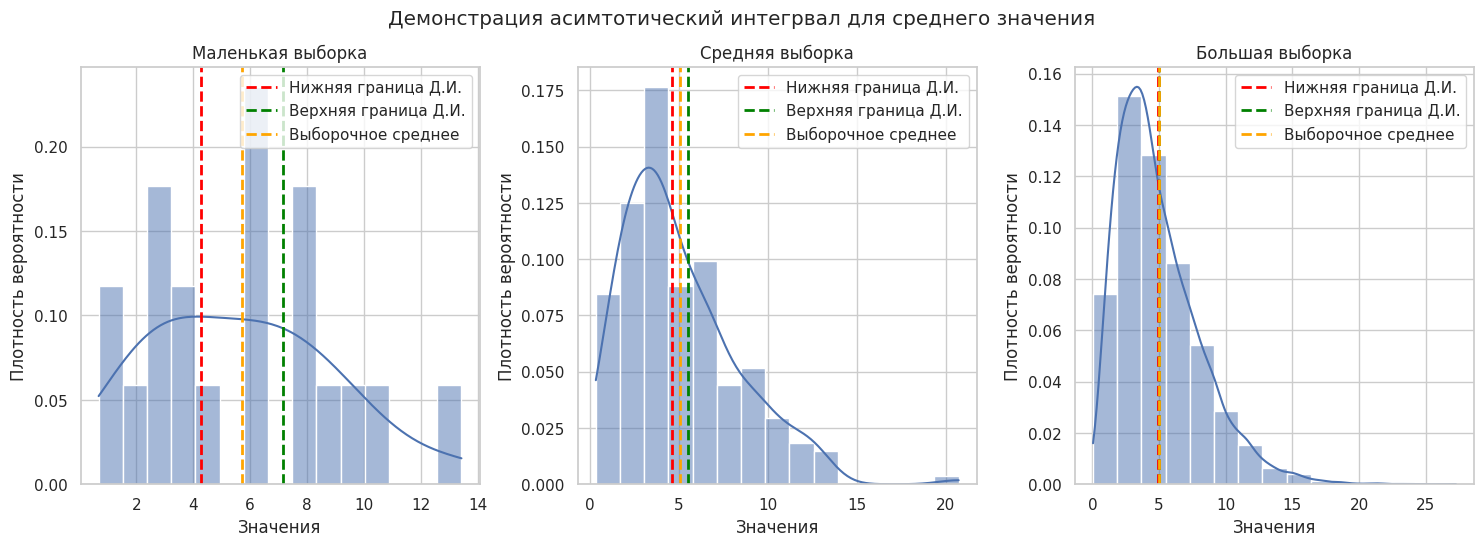

In [12]:
show_graph(samples, 
           "асимтотический интегрвал для среднего значения", 
           calc_ci_z)

### Задание №3.2

Напишем функцию для построения точного доверительного интервала для среднего значения. Точный доверительный инетервал строиться на распределении Студента.
$$
    \hat{x} \ \pm \ t_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}
$$
Где $z_{1-\frac{\alpha}{2}}$ - это квантиль распределения Студента для заданного уровня значимости, где количество степеней свободы равно количеству значений в выборке -1.

In [13]:
def calc_ci_t(sample: np.ndarray, 
              alpha: float = 0.05) -> tuple:
    t_score = t(len(sample) - 1).ppf(1 - alpha / 2)
    
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    
    margin_of_error = t_score * \
        (sample_std / np.sqrt(len(sample)))
    confidence_interval = (
         sample_mean - margin_of_error, 
         sample_mean + margin_of_error)
    interval_width = 2 * margin_of_error
    return ("Точный доверительный интервал", 
            np.round(sample_mean, 4), 
            np.round(confidence_interval, 4), 
            np.round(interval_width, 4))

Для каждой выборки выведем асимптотический доверительный интервал для среднего значения.

Значения точного интегрвала для среднего значения для маленькая выборка:[4.1688 7.2609], его ширина 3.0922
	 Выборочное среднее = 5.7148
Значения точного интегрвала для среднего значения для средняя выборка:[4.6225 5.5246], его ширина 0.9021
	 Выборочное среднее = 5.0736
Значения точного интегрвала для среднего значения для большая выборка:[4.8965 5.0187], его ширина 0.1222
	 Выборочное среднее = 4.9576


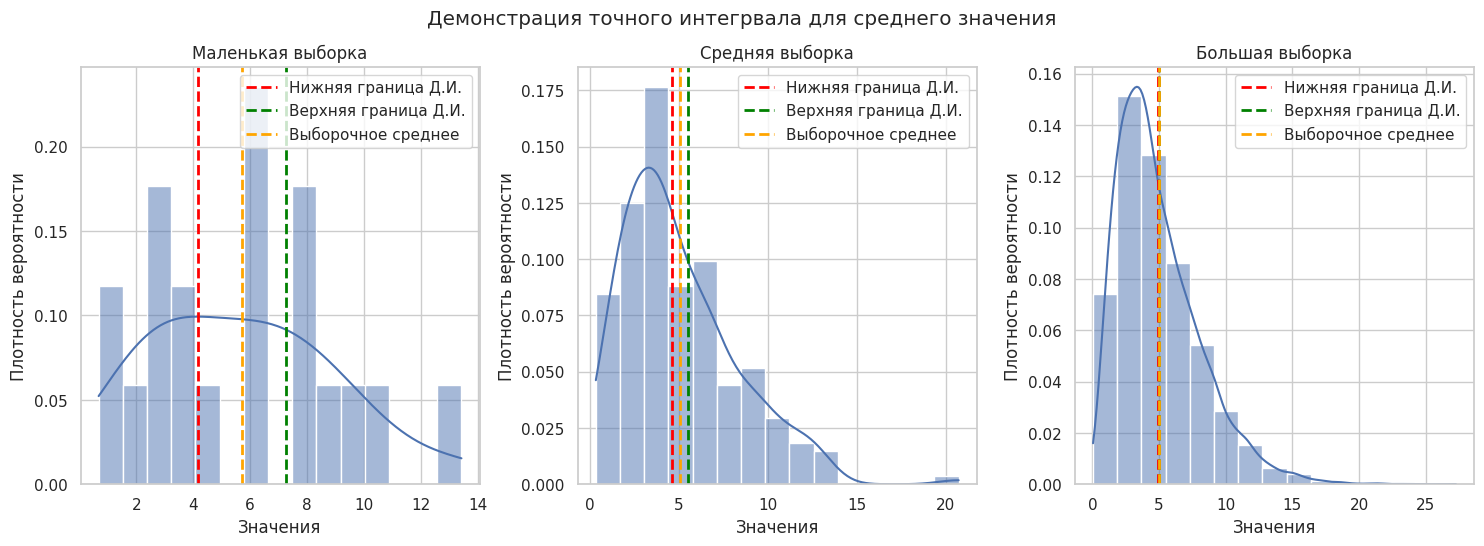

In [14]:
show_graph(samples, 
           "точного интегрвала для среднего значения", 
           calc_ci_t)

### Задание №3.3

Построим эфронов доверительный интервал для среднего, медианы, моды, дисперсии. Эфроновы доверительные интервалы строятся на базе бутстрапа. Напишем функцию для вычисления доверительных интервалов для необходимых статистик. Отдельно обработаем случай для моды, будем округлять до 1 знака после запятой.

In [15]:
russian_names = {'mean':'среднее', 
                     'mode':'мода', 
                     'median':'медиана',
                     'var':'дисперсия'}

def efron_ci_stat(sample: np.ndarray, 
                  stat_func: Callable, 
                  num_bootstrap_samples: int = 1_000, 
                  alpha: float = 0.05) -> tuple:
    bootstrap_stats = []
    
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = resample(sample)
        if stat_func is mode:
            bootstrap_sample = np.round(bootstrap_sample, 1)
            bootstrap_stats.append(stat_func(bootstrap_sample)[0])
        else:
            bootstrap_stats.append(stat_func(bootstrap_sample))
    
    lower_bound = np.percentile(bootstrap_stats, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_stats, (1 - alpha / 2) * 100)

    confidence_interval = [lower_bound, upper_bound]
    interval_width = upper_bound - lower_bound
    margin_of_error = interval_width / 2 
    return (f'Эфронов доверительный интервал для'
             '{russian_names[stat_func.__name__]}',
            np.round(bootstrap_stats, 4),
            np.round(margin_of_error, 4), 
            np.round(confidence_interval, 4), 
            np.round(interval_width, 4))

Демонстрация эфронова доверительного интервала длясреднее:
	 Значения доверительного интервала для маленькая выборка:[4.4131 7.0787], его ширина 2.6657
	 Значения доверительного интервала для средняя выборка:[4.6396 5.5053], его ширина 0.8657
	 Значения доверительного интервала для большая выборка:[4.8924 5.0224], его ширина 0.13


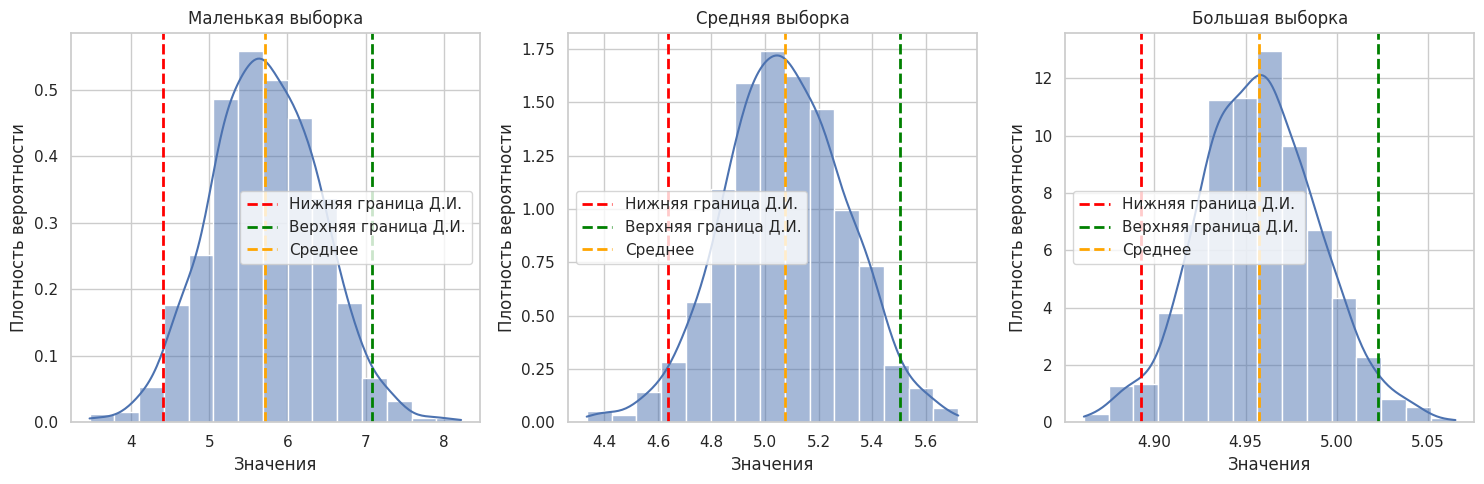


Демонстрация эфронова доверительного интервала длямедиана:
	 Значения доверительного интервала для маленькая выборка:[3.0604 7.5217], его ширина 4.4613
	 Значения доверительного интервала для средняя выборка:[3.7763 4.774 ], его ширина 0.9977
	 Значения доверительного интервала для большая выборка:[4.207  4.3415], его ширина 0.1346


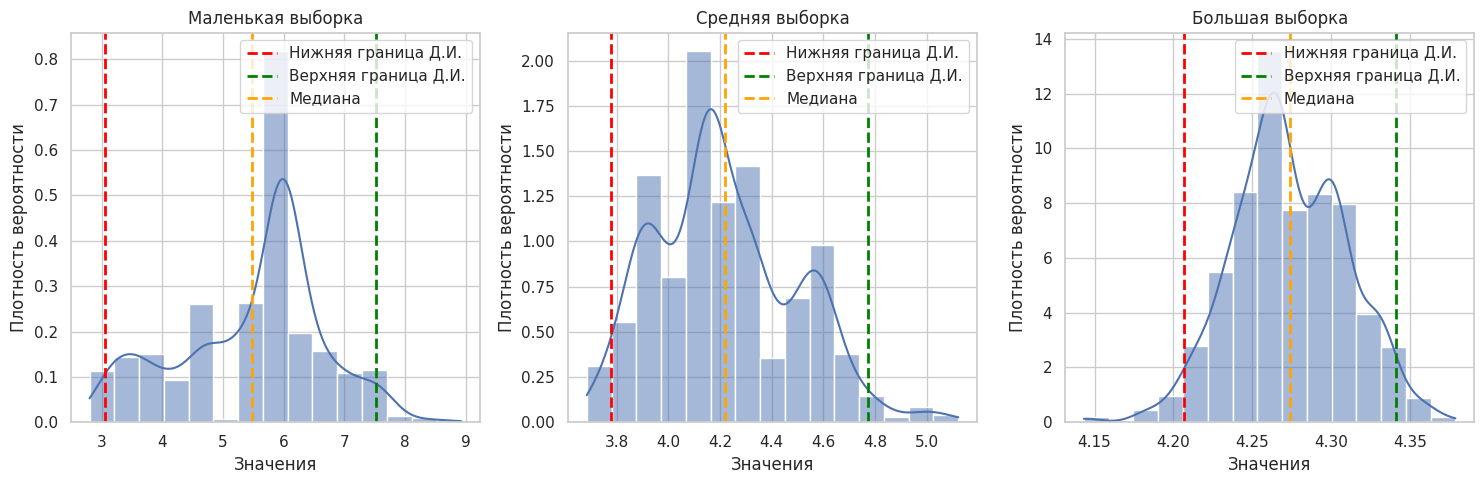


Демонстрация эфронова доверительного интервала длямода:
	 Значения доверительного интервала для маленькая выборка:[ 0.7 10.3], его ширина 9.6
	 Значения доверительного интервала для средняя выборка:[1.2 9. ], его ширина 7.8
	 Значения доверительного интервала для большая выборка:[2.1   3.905], его ширина 1.805


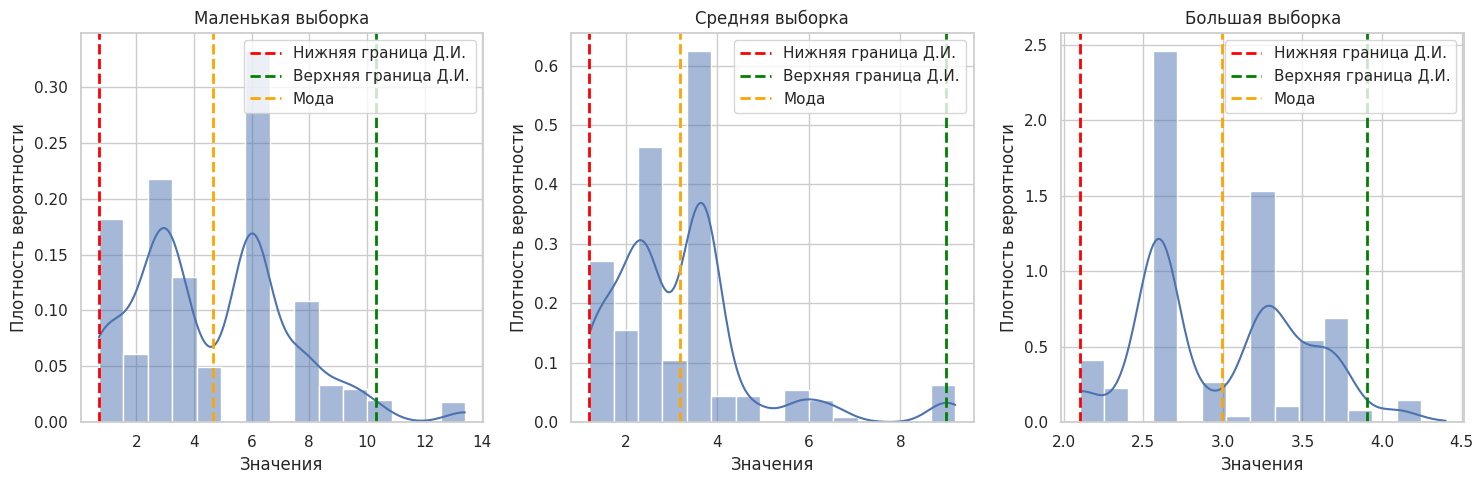


Демонстрация эфронова доверительного интервала длядисперсия:
	 Значения доверительного интервала для маленькая выборка:[ 4.8067 16.1542], его ширина 11.3475
	 Значения доверительного интервала для средняя выборка:[ 7.737 13.612], его ширина 5.8749
	 Значения доверительного интервала для большая выборка:[ 9.3486 10.0962], его ширина 0.7476


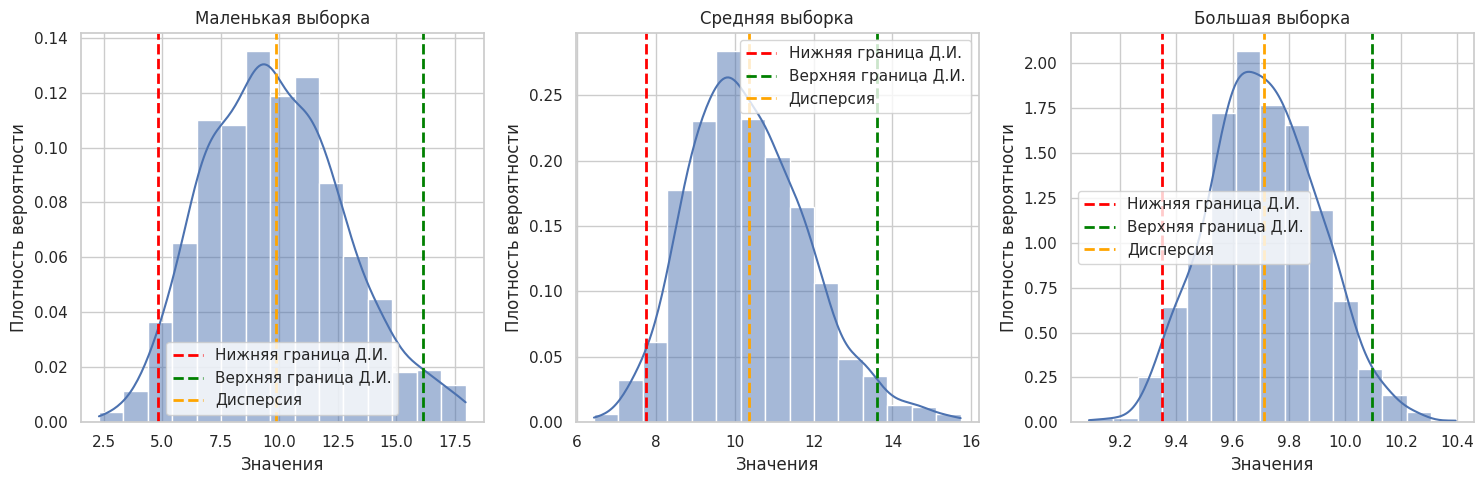

In [16]:
stat_funcs = [np.mean, np.median, mode, np.var]
for stat_func in stat_funcs:
    print(f'Демонстрация эфронова доверительного интервала для'
          f'{russian_names[stat_func.__name__]}:')
    plt.figure(figsize=(15, 5))
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        
        _, bootstrap_stats, __, confidence_interval, interval_width = \
        efron_ci_stat(sample.values, stat_func)
            
        print(f'\t Значения доверительного интервала для {sample.name}:'
              f'{confidence_interval}, его ширина {interval_width}')
            
        sns.histplot(bootstrap_stats, 
                     bins=15, 
                     kde=True,
                     stat='density')
        plt.axvline(x=confidence_interval[0], 
                    color='red', 
                    linestyle='dashed', 
                    linewidth=2, 
                    label='Нижняя граница Д.И.')
        plt.axvline(x=confidence_interval[1], 
                    color='green', 
                    linestyle='dashed', 
                    linewidth=2, 
                    label='Верхняя граница Д.И.')
        if stat_func == mode:
            res = stat_func(sample.values)[0]
        else:
            res = stat_func(sample.values)
        plt.axvline(x=np.mean(bootstrap_stats), 
                    color='orange', 
                    linestyle='dashed', 
                    linewidth=2, 
                    label=russian_names[stat_func.__name__]\
                    .capitalize())
        plt.title(f'{sample.name.capitalize()}')
        plt.xlabel('Значения')
        plt.ylabel('Плотность вероятности')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    print()

### Итог для 3-тьего задания 

Выведем сводную таблицу для построения выводов.

In [18]:
data = []

for sample in samples:
    ci_z = calc_ci_z(sample.values)
    name, _, confidence_interval, interval_width = \
        calc_ci_z(sample.values)
    data.append({'sample_name': sample.name.capitalize(),
                     'stat_func': 'среднее'.capitalize(), 
                     'method_name': name, 
                     'confidence_interval': confidence_interval, 
                     'interval_width': interval_width})
    
    ci_t = calc_ci_t(sample.values)
    name, _, confidence_interval, interval_width = \
        calc_ci_t(sample.values)
    data.append({'sample_name': sample.name.capitalize(),
                     'stat_func': 'среднее'.capitalize(), 
                     'method_name': name, 
                     'confidence_interval': confidence_interval, 
                     'interval_width': interval_width})

    for stat_func in stat_funcs:
        name, bootstrap_stats, _, confidence_interval, interval_width = \
            efron_ci_stat(sample.values, stat_func)
        data.append({'sample_name': sample.name.capitalize(),
                     'stat_func': russian_names[stat_func.__name__].capitalize(), 
                     'method_name': ' '.join(name.split()[:-2]), 
                     'confidence_interval': confidence_interval, 
                     'interval_width': interval_width})
for line in data:
    true_val = 5
    if line['stat_func'] == 'Дисперсия':
        true_val = 10
    if line['stat_func'] == 'Медиана':
        true_val = 4.3
    if line['stat_func'] == 'Мода':
        true_val = 3
    line['true_val'] = true_val
        

df = pd.DataFrame(data).sort_values(['sample_name', 
                                     'stat_func', 
                                     'method_name']).\
    reset_index(drop=True)
df.rename(columns = {'sample_name': 'Название выборки',
                     'stat_func': 'Статистика',
                     'method_name': 'Название метода', 
                     'confidence_interval': 'Д. И.',
                     'interval_width': 'Ширина Д. И.',
                     'true_val': 'Cтатистика из Г. С.'})

,Название выборки,Статистика,Название метода,Д. И.,Ширина Д. И.,Cтатистика из Г. С.
0,Большая выборка,Дисперсия,Эфронов доверительный,"[9.3386, 10.0933]",0.7547,10.0
1,Большая выборка,Медиана,Эфронов доверительный,"[4.2047, 4.3446]",0.1399,4.3
2,Большая выборка,Мода,Эфронов доверительный,"[2.1, 4.1]",2.0000,3.0
3,Большая выборка,Среднее,Асимтотический доверительный интервал,"[4.8965, 5.0186]",0.1221,5.0
4,Большая выборка,Среднее,Точный доверительный интервал,"[4.8965, 5.0187]",0.1222,5.0
5,Большая выборка,Среднее,Эфронов доверительный,"[4.8908, 5.0199]",0.1291,5.0
6,Маленькая выборка,Дисперсия,Эфронов доверительный,"[5.1375, 16.1723]",11.0348,10.0
7,Маленькая выборка,Медиана,Эфронов доверительный,"[3.0604, 7.5217]",4.4613,4.3
8,Маленькая выборка,Мода,Эфронов доверительный,"[0.7, 10.3]",9.6000,3.0
9,Маленькая выборка,Среднее,Асимтотический доверительный интервал,"[4.267, 7.1626]",2.8956,5.0


#### Интерпритируем результаты 

#### **Эфронов доверительный интервал**

Первое, что бросается в глаза - это большая ширина для моды, он в разы отличается от доверительных интервалов для других характеристик. Связано это с тем, что мода очень вариативная характеристика, в отличие, к примеру, от среднего (стоит отметить, что вычисление моды производилось с округлением, что "дискретизирует" непрерывную величину). Так же большой доверительный интервал имеет дисперсия, точно по этой же причине.

#### **Точный доверительный интервал**
Точный доверительный интервал, в сравнении с остальными методами построения доверительных интервалов, имеет немного большую ширину, связано это с тем, что этот метод учитывает количество данных в выборке.

### **Асимптотический доверительный интервал**
Тут сказать нечего.

### **Итог**
Мы видим, что все доверительные интервалы включают в себя значения статистик из генеральной совокупности, кроме того, мы обратную зависимость количества значений в выборке и ширины доверительного интервала.